# Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras import optimizers
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Dropout, BatchNormalization, Activation

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
print('Train set overview:')
display(train.head())

Train set shape: (262144, 258)
Test set shape: (131073, 257)
Train set overview:


,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

# EDA

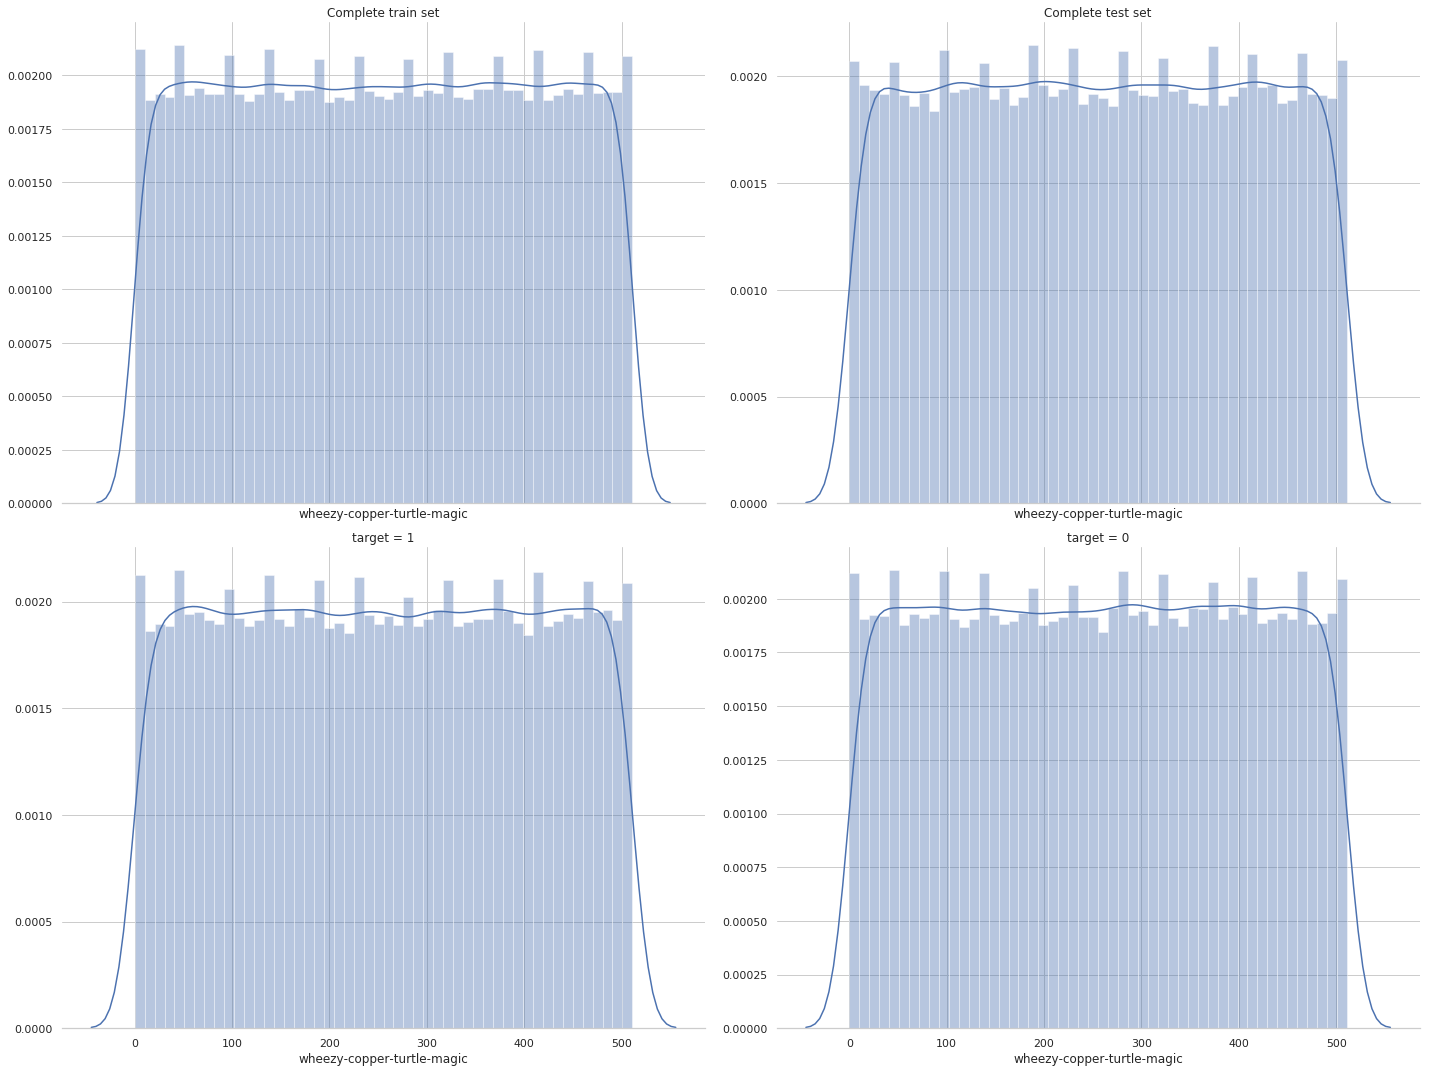

In [3]:
f, axes = plt.subplots(2, 2, figsize=(20, 15), sharex=True)
sns.distplot(train['wheezy-copper-turtle-magic'], ax=axes[0][0]).set_title("Complete train set")
sns.distplot(test['wheezy-copper-turtle-magic'], ax=axes[0][1]).set_title("Complete test set")
sns.distplot(train[train['target']==1]['wheezy-copper-turtle-magic'], ax=axes[1][0]).set_title("target = 1")
sns.distplot(train[train['target']==0]['wheezy-copper-turtle-magic'], ax=axes[1][1]).set_title("target = 0")
sns.despine(left=True)
plt.tight_layout()

## Process data for model

### Turn "wheezy-copper-turtle-magic" into a categorical feature

In [4]:
train['set'] = 0
test['set'] = 1
data = pd.concat([train, test])

In [5]:
data['magic_odd'] = data['wheezy-copper-turtle-magic'].apply(lambda x: x % 2)
data['magic_4'] = data['wheezy-copper-turtle-magic'].apply(lambda x: x % 4)
data['magic_9'] = data['wheezy-copper-turtle-magic'].apply(lambda x: x % 9)

In [6]:
data['count_magic'] = data.groupby(['wheezy-copper-turtle-magic'])['id'].transform('count')
data = pd.concat([data, pd.get_dummies(data['wheezy-copper-turtle-magic'], prefix='magic', drop_first=True)], axis=1).drop(['wheezy-copper-turtle-magic'], axis=1)

### Train/validation random split (80% train / 20% validation)

In [7]:
data.drop('id', axis=1, inplace=True)
train = data[data['set'] == 0]
test = data[data['set'] == 1]
labels = train['target']
train.drop(['target', 'set'], axis=1, inplace=True)
test.drop(['target', 'set'], axis=1, inplace=True)

X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.2, random_state=1)

print('Train set shape:', X_train.shape)
print('Validation set shape:', X_val.shape)
print('Test set shape:', test.shape)
display(X_train.head())

Train set shape: (209715, 770)
Validation set shape: (52429, 770)
Test set shape: (131073, 770)


,baggy-champagne-capuchin-discard,baggy-copper-oriole-dummy,baggy-coral-bandicoot-unsorted,baggy-mustard-collie-hint,beady-aquamarine-affenpinscher-grandmaster,beady-asparagus-opossum-expert,beady-champagne-bullfrog-grandmaster,beady-lilac-hornet-expert,beady-mauve-frog-distraction,beady-orange-binturong-golden,beady-rust-impala-dummy,bluesy-amber-walrus-fepid,bluesy-amethyst-octopus-gaussian,bluesy-brass-chihuahua-distraction,bluesy-chocolate-kudu-fepid,bluesy-rose-wallaby-discard,blurry-amber-moth-dataset,blurry-buff-hyena-entropy,blurry-flax-sloth-fepid,blurry-green-dodo-important,blurry-sangria-saola-gaussian,blurry-wisteria-oyster-master,boozy-amethyst-tarsier-dataset,breezy-aquamarine-sloth-sorted,breezy-magenta-loon-hint,breezy-myrtle-loon-discard,breezy-persimmon-newt-noise,bumpy-amaranth-armadillo-important,bumpy-amaranth-bonobo-gaussian,cheeky-pear-horse-fimbus,cheeky-plum-fox-noise,cheeky-red-armadillo-unsorted,chewy-bistre-buzzard-expert,chewy-lime-peccary-fimbus,chewy-myrtle-wasp-important,chummy-cream-tarantula-entropy,chummy-ruby-chinook-dataset,clammy-scarlet-emu-important,clammy-xanthic-affenpinscher-golden,cozy-khaki-reindeer-golden,...,magic_472,magic_473,magic_474,magic_475,magic_476,magic_477,magic_478,magic_479,magic_480,magic_481,magic_482,magic_483,magic_484,magic_485,magic_486,magic_487,magic_488,magic_489,magic_490,magic_491,magic_492,magic_493,magic_494,magic_495,magic_496,magic_497,magic_498,magic_499,magic_500,magic_501,magic_502,magic_503,magic_504,magic_505,magic_506,magic_507,magic_508,magic_509,magic_510,magic_511
38395,-1.311351,0.433736,1.422726,-0.517484,0.980541,-0.891344,-0.550517,-0.784922,0.898501,-0.528981,0.442054,-0.479226,-0.244638,1.257341,-0.674525,0.421287,-0.541398,-0.555186,1.259385,5.987485,-0.504381,0.823473,-0.398144,-3.464912,-1.088800,-1.158602,-0.111903,1.151368,-0.162980,-1.866952,-0.251835,0.020353,2.250326,0.230614,0.983004,0.131855,0.434435,-1.532635,-0.032818,1.007735,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
199220,0.785335,0.951612,0.632335,1.150369,-0.695757,0.837305,0.936503,2.304856,1.470529,1.195119,-0.053678,-0.685696,0.453897,0.049716,0.596532,0.366653,0.643883,0.216068,4.514261,0.098165,-0.752644,1.062266,-0.314727,1.789479,0.895000,0.314284,-1.921109,0.435156,-0.527973,-1.474225,3.956501,0.332356,0.649227,-0.266317,2.494314,-1.628547,-1.781490,-0.854768,-1.448743,1.150329,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
198726,1.104387,-1.230115,-1.440088,1.496325,-0.070311,0.114106,0.769511,1.057316,7.809155,0.917445,0.464907,0.578133,0.303087,1.069591,1.437438,-0.452083,0.685644,0.276095,0.174464,0.680365,-1.080508,0.578409,-0.281801,-0.548075,0.061064,0.975063,-0.457197,1.584074,-0.091635,0.113535,0.057819,1.948243,-0.194324,1.844885,-1.358323,0.930242,-1.218634,0.063482,-0.280959,-0.564239,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47196,-0.973502,-0.524860,0.738675,1.338597,1.838354,0.341762,2.713976,0.028380,0.211751,-0.183448,-0.696947,1.347159,0.055530,0.217591,0.721928,0.113880,-0.132929,1.372269,7.412355,2.289853,-0.442595,1.214569,-0.476689,0.771206,1.921864,0.259217,-3.215024,0.091762,7.741626,-0.067105,-1.018873,-1.847234,-2.351950,-0.673162,-1.184836,1.538755,-1.463687,-0.601395,-1.712373,1.729320,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69040,0.980294,0.688717,-0.165971,1.404211,-0.253241,0.356709,1.015068,0.313294,-1.370233,-2.268744,-6.040200,-0.560045,-1.211587,-0.061577,-2.145119,0.092530,0.167232,5.299827,0.135423,1.625357,6.832893,0.580538,8.147537,0.546506,1.401511,5.794694,1.263359,-0.262759,-0.600327,-0.201033,-0.441921,-0.734262,0.338174,2.132646,1.450677,-0.423579,0.476935,-0.742969,0.605640,0.018293,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Normalize data using MinMaxScaler

In [8]:
non_cat_features = list(train.filter(regex='^(?!magic_)'))
scaler = MinMaxScaler()
X_train[non_cat_features] = scaler.fit_transform(X_train[non_cat_features])
X_val[non_cat_features] = scaler.transform(X_val[non_cat_features])
test[non_cat_features] = scaler.transform(test[non_cat_features])

# Model

## Model parameters

In [9]:
BATCH_SIZE = 256
EPOCHS = 30
LEARNING_RATE = 0.001
ES_PATIENCE = 5
RLROP_PATIENCE = 3
RLROP_FACTOR = 0.5

In [10]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=RLROP_FACTOR, min_lr=1e-6, verbose=1)
callback_list = [es, rlrop]

optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['binary_accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               394752    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2

In [11]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                    callbacks=callback_list, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 209715 samples, validate on 52429 samples
Epoch 1/30
 - 15s - loss: 0.7169 - binary_accuracy: 0.5030 - val_loss: 0.6930 - val_binary_accuracy: 0.5049
Epoch 2/30
 - 13s - loss: 0.6927 - binary_accuracy: 0.5212 - val_loss: 0.6898 - val_binary_accuracy: 0.5321
Epoch 3/30
 - 13s - loss: 0.6868 - binary_accuracy: 0.5470 - val_loss: 0.6962 - val_binary_accuracy: 0.5224
Epoch 4/30
 - 13s - loss: 0.6745 - binary_accuracy: 0.5769 - val_loss: 0.7297 - val_binary_accuracy: 0.5161
Epoch 5/30
 - 13s - loss: 0.6517 - binary_accuracy: 0.6151 - val_loss: 0.6787 - val_binary_accuracy: 0.5744
Epoch 6/30
 - 13s - loss: 0.6216 - binary_accuracy: 0.6537 - val_loss: 0.6313 - val_binary_accuracy: 0.6403
Epoch 7/30
 - 13s - loss: 0.5926 - binary_accuracy: 0.6832 - val_loss: 0.6187 - val_binary_accuracy: 0.6528
Epoch 8/30
 - 14s - loss: 0.5701 - binary_accuracy: 0.7025 - val_loss: 0.6016 - val_binary_accuracy: 0.6731
Epoch 9/30
 - 13s - loss: 0.5492 - bi

### Model graph loss

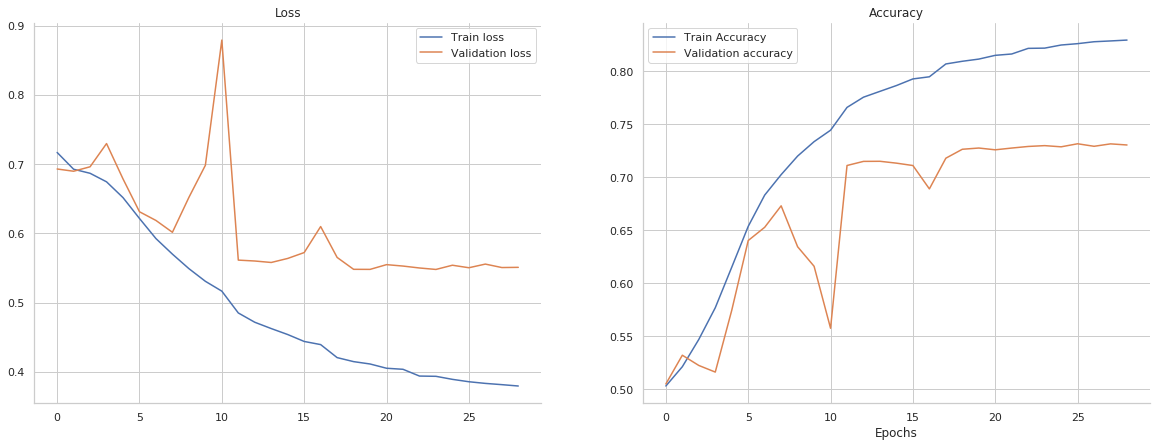

In [12]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20, 7))

ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['binary_accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_binary_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model evaluation

## Confusion matrix

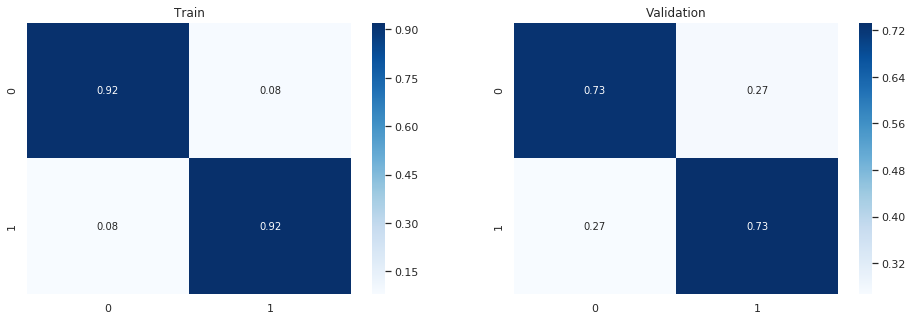

In [13]:
train_pred = model.predict_classes(X_train)
val_pred = model.predict_classes(X_val)

f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, train_pred)
val_cnf_matrix = confusion_matrix(Y_val, val_pred)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
val_cnf_matrix_norm = val_cnf_matrix / val_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
val_df_cm = pd.DataFrame(val_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=axes[0]).set_title("Train")
sns.heatmap(val_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=axes[1]).set_title("Validation")
plt.show()

## Metrics ROC AUC

In [14]:
print('Train AUC %.2f' % roc_auc_score(Y_train.values, train_pred))
print('Validation AUC %.2f' % roc_auc_score(Y_val.values, val_pred))

Train AUC 0.92
Validation AUC 0.73


# Test predictions

In [15]:
predictions = model.predict(test)
df = pd.read_csv('../input/sample_submission.csv')
df['target'] = predictions
df.to_csv('submission.csv', index=False)
df.head(10)

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.195792
1,ba88c155ba898fc8b5099893036ef205,0.893232
2,7cbab5cea99169139e7e6d8ff74ebb77,0.685970
3,ca820ad57809f62eb7b4d13f5d4371a0,0.347977
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.101008
5,8b3116e5e3e92e971dac305d1a093bf6,0.361205
6,35cfd7cab9bfa29bc963d1b8c94dd280,0.031770
7,83cf532df8ff4642a3e33a70fffdac37,0.336415
8,2e1350fe94ec9f2220bec5245e5e9265,0.814437
9,e62020afa72eb54a15725473e3a8475b,0.235750
